# 年間配当額の推移

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/J-Quants/jquants-api-client-python/blob/master/examples/20220825-004-annual-dividend-history.ipynb)

このノートブックでは J-Quants APIから取得できるデータを利用して特定銘柄についての年間配当額の推移を表示します。


----

**このノートブックはGoogle Driveを使用します。**

- Google Drive の以下のファイルにリフレッシュトークンが書き込まれていることを想定しています。
    - `MyDrive/drive_ws/secret/jquantsapi-key.txt`

In [1]:
# python version　3｡10｡9で動作確認
!python --version

Python 3.10.9


In [2]:
# 年間配当額の推移を表示する銘柄コードを指定します (e.g. 8697)
TARGET_SYMBOL = "8697"  # 日本取引所グループ

In [3]:
# 必要なモジュールをインストールします。
! python -m pip install jquants-api-client japanize-matplotlib mplfinance


In [4]:
import os
from datetime import datetime

import japanize_matplotlib
import jquantsapi
import mplfinance as mpf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [5]:
# pandas の表示制限を調整します
pd.set_option("display.max_rows", 1000)
pd.set_option("display.max_columns", 1000)
pd.set_option("display.width", 2000)

In [6]:
# プロット用の設定をします
sns.set(rc={'figure.figsize': (15, 10)})
sns.set(font_scale=1.5)
sns.set_style('whitegrid')

japanize_matplotlib.japanize()

In [7]:
# 銘柄コードが4桁で指定されていた場合は末尾に0を付与します
if len(TARGET_SYMBOL) == 4:
    TARGET_SYMBOL += "0"

In [8]:
# J-Quants APIのトークンを保存してあるファイルを指定します
REFRESH_TOKEN_FILE_PATH = "../drive_ws/secret/jquantsapi-key.txt"

In [9]:
def get_refresh_token(refresh_token_file_path: str = REFRESH_TOKEN_FILE_PATH):
    with open(refresh_token_file_path, "r") as f:
        refresh_token = f.read()
    return refresh_token.rstrip().lstrip()

In [10]:
# ファイルからリフレッシュトークンを読み込みます
refresh_token = get_refresh_token()

In [11]:
# J-Quants APIクライアントを初期化します
jqapi = jquantsapi.Client(refresh_token=refresh_token)

In [12]:
# 銘柄情報を取得します
df_list = jqapi.get_list()

In [13]:
# 対象銘柄の株価情報を取得します
df_p_org = jqapi.get_prices_daily_quotes(code=TARGET_SYMBOL)

In [14]:
# 作業用にコピーします
df_p = df_p_org.copy()

# 各列のデータ型を調整します
df_p.loc[:, "Date"] = pd.to_datetime(df_p["Date"], format="%Y-%m-%d")
df_p.loc[:, "Open"] = df_p["Open"].astype(np.float64)
df_p.loc[:, "High"] = df_p["High"].astype(np.float64)
df_p.loc[:, "Low"] = df_p["Low"].astype(np.float64)
df_p.loc[:, "Close"] = df_p["Close"].astype(np.float64)
df_p.loc[:, "Volume"] = df_p["Volume"].astype(np.float64)
df_p.loc[:, "TurnoverValue"] = df_p["TurnoverValue"].astype(np.float64)
df_p.loc[:, "AdjustmentFactor"] = df_p["AdjustmentFactor"].astype(np.float64)
df_p.loc[:, "AdjustmentOpen"] = df_p["AdjustmentOpen"].astype(np.float64)
df_p.loc[:, "AdjustmentHigh"] = df_p["AdjustmentHigh"].astype(np.float64)
df_p.loc[:, "AdjustmentLow"] = df_p["AdjustmentLow"].astype(np.float64)
df_p.loc[:, "AdjustmentClose"] = df_p["AdjustmentClose"].astype(np.float64)
df_p.loc[:, "AdjustmentVolume"] = df_p["AdjustmentVolume"].astype(np.float64)
# 株価が0のレコードを除外します
df_p = df_p.replace({0.0: np.nan}).dropna()
# 月足のOHLCVを作成します
df_p_m_ohlc = df_p.set_index("Date")[[
    "AdjustmentOpen",
    "AdjustmentHigh",
    "AdjustmentLow",
    "AdjustmentClose",
    "AdjustmentVolume"
]].rename(columns={
    "AdjustmentOpen": "Open",
    "AdjustmentHigh": "High",
    "AdjustmentLow": "Low",
    "AdjustmentClose": "Close",
    "AdjustmentVolume": "Volume",
}).resample("M").agg({"Open": "first", "High": "max", "Low": "min", "Close": "last", "Volume": "sum"})

/var/folders/kx/n6w_n8193fn6dy4jwf3fsr6w0000gn/T/ipykernel_97452/4149053356.py:5: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df_p.loc[:, "Date"] = pd.to_datetime(df_p["Date"], format="%Y-%m-%d")


In [15]:
# 対象銘柄の財務情報を取得します
df_s_org = jqapi.get_fins_statements(code=TARGET_SYMBOL)

In [16]:
# 作業用にコピーします
df_s = df_s_org.copy()

# 年度末情報に絞り込みます
df_s = df_s.loc[df_s["TypeOfCurrentPeriod"] == "FY"]
# float64にするために"-"および""をnp.nanに置き換えます
df_s.replace({"－": np.nan, "": np.nan}, inplace=True)
df_s.loc[:, "ResultDividendPerShareAnnual"] = df_s["ResultDividendPerShareAnnual"].astype(np.float64)
df_s.loc[:, "ForecastDividendPerShareAnnual"] = df_s["ForecastDividendPerShareAnnual"].astype(np.float64)
df_s.loc[:, "EarningsPerShare"] = df_s["EarningsPerShare"].astype(np.float64)

# 日付型に変換します
df_s.loc[:, "DisclosedDate"] = pd.to_datetime(
    df_s["DisclosedDate"], format="%Y-%m-%d"
)
df_s.loc[:, "CurrentPeriodEndDate"] = pd.to_datetime(
    df_s["CurrentPeriodEndDate"], format="%Y-%m-%d"
)
df_s.loc[:, "CurrentFiscalYearStartDate"] = pd.to_datetime(
    df_s["CurrentFiscalYearStartDate"], format="%Y-%m-%d"
)
df_s.loc[:, "CurrentFiscalYearEndDate"] = pd.to_datetime(
    df_s["CurrentFiscalYearEndDate"], format="%Y-%m-%d"
)
# 開示順に並べ替えます
df_s.sort_values("DisclosedUnixTime", inplace=True)

# 配当性向を算出します
df_s["配当性向"] = df_s["ResultDividendPerShareAnnual"] / df_s["EarningsPerShare"]

/var/folders/kx/n6w_n8193fn6dy4jwf3fsr6w0000gn/T/ipykernel_97452/3443893597.py:8: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df_s.loc[:, "ResultDividendPerShareAnnual"] = df_s["ResultDividendPerShareAnnual"].astype(np.float64)
/var/folders/kx/n6w_n8193fn6dy4jwf3fsr6w0000gn/T/ipykernel_97452/3443893597.py:9: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df_s.loc[:, "ForecastDividendPerShareAnnual"] = df_s["ForecastDividendPerShareAnnual"].astype(np.float64)
/var/folders/kx/n6w_n8193fn6dy4jwf3fsr6w0000gn/T/ipykernel_97452/3443893597.py:10:

Text(0.5, 1.0, '日本取引所グループ(86970) の年間配当推移')

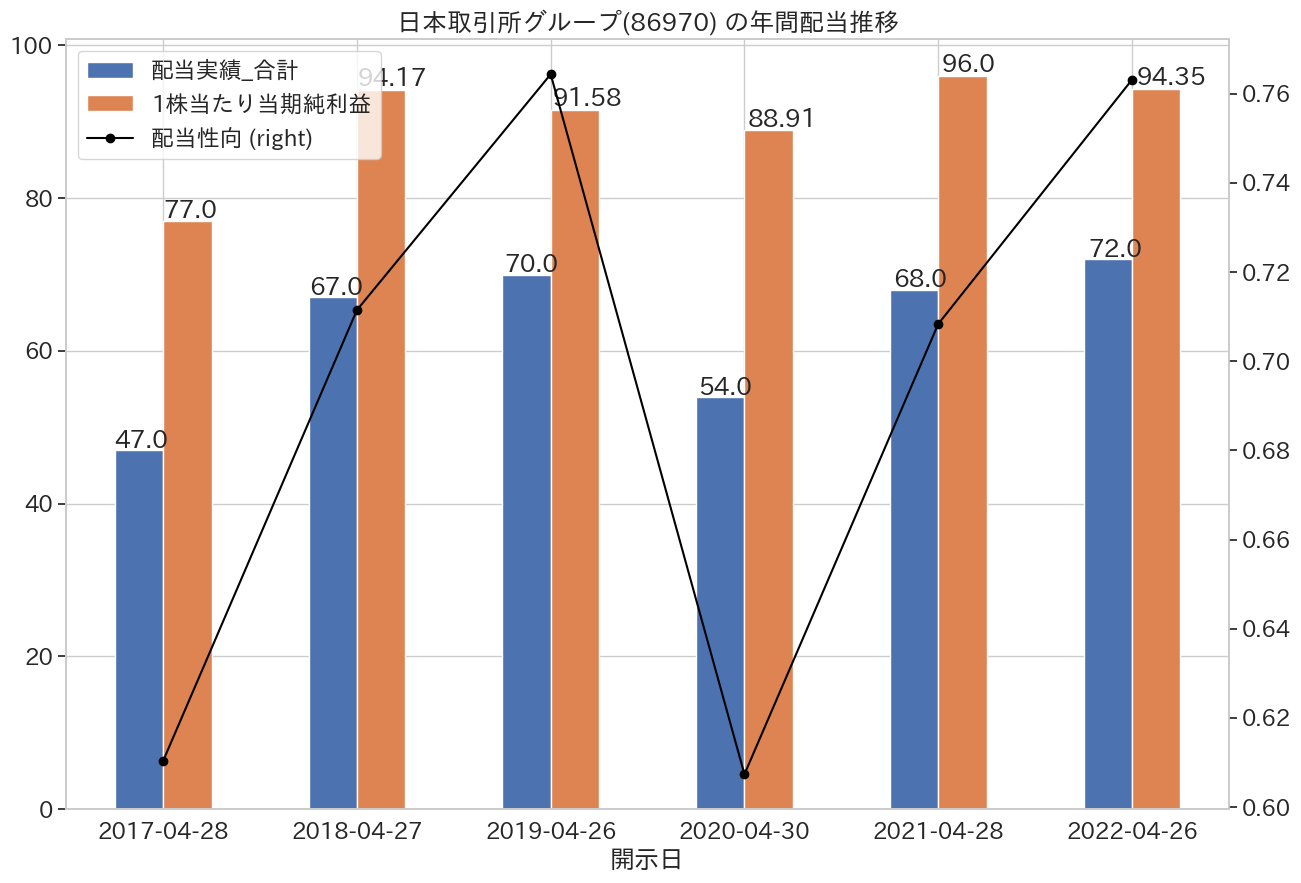

In [17]:
# プロット用に配当額が存在するレコードのみに絞り込みます
df_plot = df_s.loc[df_s["ResultDividendPerShareAnnual"].notna()].set_index("DisclosedDate")
# インデックスの表記を変更します
df_plot.index = df_plot.index.strftime("%Y-%m-%d")

# 項目名を日本語にします
df_plot.index.name = "開示日"
df_plot.rename(columns={
    "ResultDividendPerShareAnnual": "配当実績_合計",
    "EarningsPerShare": "1株当たり当期純利益",
}, inplace=True)

# 配当額と1株あたり利益をプロットします
ax = df_plot[["配当実績_合計", "1株当たり当期純利益"]].plot(kind="bar")
# 配当性向をプロットします
bx = df_plot[["配当性向"]].plot(linestyle='-', marker='o', ax=ax, use_index=False, secondary_y=True, color="black")

# 棒グラフに数字を表記します
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))

# 銘柄名を取得します
name = df_list.loc[df_list["Code"] == TARGET_SYMBOL, "CompanyName"].iat[0]

# タイトルを設定します
ax.set_title(f"{name}({TARGET_SYMBOL}) の年間配当推移")

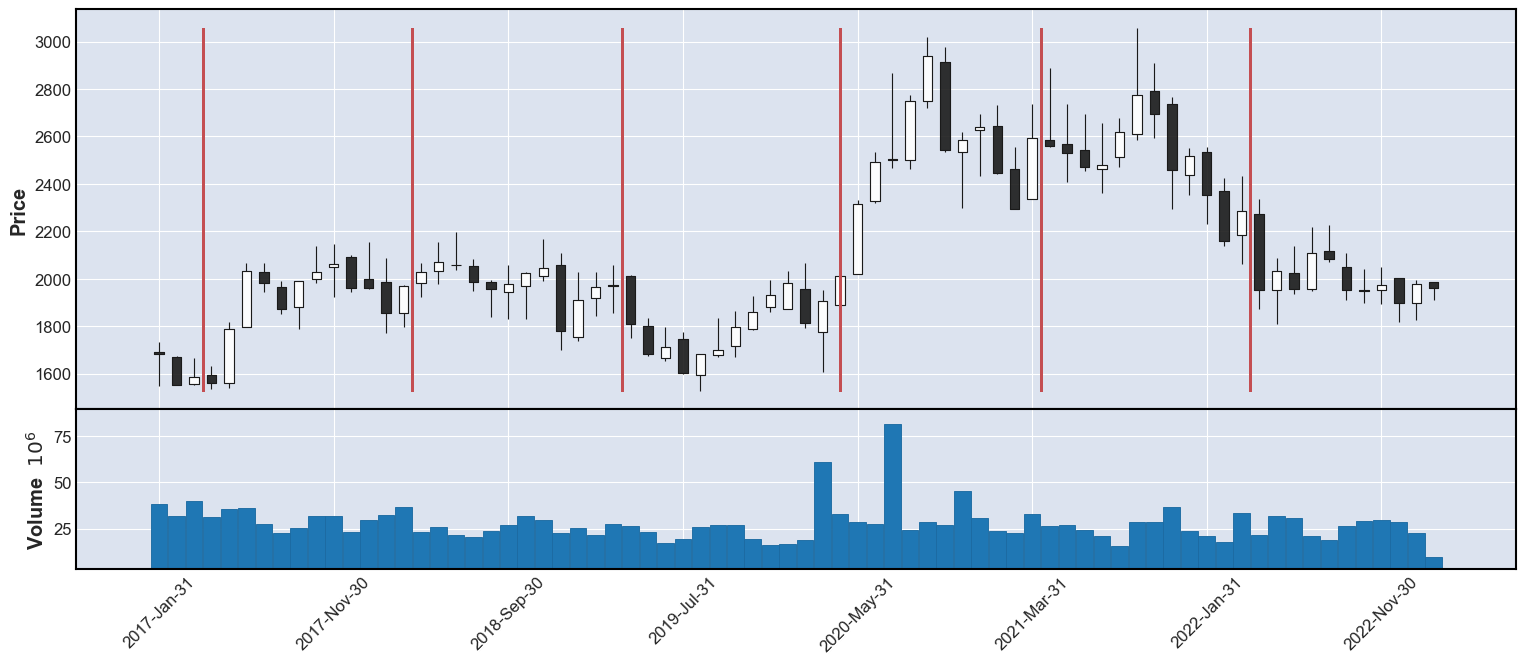

In [18]:
# 株価の推移を月足で表示します
mpf.plot(df_p_m_ohlc, type="candle", volume=True, figsize=(20, 8), vlines={"vlines": df_plot.index.tolist(), "colors": "r"})